# Machine Learning Homework 1
### Classifying MNIST Digits using a Perceptron

In [1]:
import numpy as np                            # The bread and butter library for this homework
import pandas as pd                           # Reading in data is hard, Pandas makes it easy
import matplotlib.pyplot as plt               # Because why do all this work and then copy/paste in excel?
from sklearn.metrics import confusion_matrix  # Okay, this is just outright cheating / laziness
from datetime import datetime, timedelta      # Keep track of how long things are taking

In [2]:
assignment_start = datetime.now()
etas = [0.001, 0.01, 0.1]  # The learning rates required for the assignment
targets = np.eye(10)       # This creates a 10x10 identity matrix
training_accuracy = {}
testing_accuracy = {}

## Using Pandas to read in data:
---
Pandas is a wonderful library that makes data input and data manipulation simple and fast. (That said, operations like matrix multiplication can be extraordinarily slow, so don't use it for that.) One nice feature is the `read_csv()` function. The MNIST Digit data set CSV does not have a header row, and the target values for each instance can be found in the first column. So what we can do to make things easy is to set the `header` parameter to `None` and set the `index_col` parameter to 0. The former is self-explanatory, and the latter sets an immutable column taken from column 0 in the CSV. Conveniently, the first column is the target values. 

Also, note that I have scaled the data in one step by dividing the dataframe by 255.0. This reads and processes the data in one line of code. 

In [3]:
training_data = pd.read_csv('../data/mnist_train.csv', header=None, index_col=0) / 255.0

In [4]:
testing_data = pd.read_csv('../data/mnist_test.csv', header=None, index_col=0) / 255.0

## Add the bias
---
There is one more step that we must do because of how the perceptron works. We need to add in a column of bias weights. Normally, adding a bias could be a reasonably tedious process, but Pandas makes it easy. The `loc` parameter is the index where the column should be inserted. The `column` parameter is the label for the column, and the `value` parameter is the column to be inserted. The value we're inserting is a numpy array that has 60,000 rows (10,000 for the test set) of one value of 1.0. The bias.

In [5]:
training_data.insert(loc=0, column=0, value=np.ones((training_data.shape[0], 1)))

In [6]:
# This extracts the numpy array of data from the pandas dataframe. 
X_train, y_train = training_data.values, training_data.index.values
X_train.shape, y_train.shape  # Just used to verify that the data was loaded

((60000, 785), (60000,))

In [7]:
testing_data.insert(loc=0, column=0, value=np.ones((testing_data.shape[0], 1)))

In [8]:
X_test, y_test = testing_data.values, testing_data.index.values
X_test.shape, y_test.shape

((10000, 785), (10000,))

In [9]:
def plot_accuracy_graphs(training, testing, eta):
    """A helper function used for plotting the accuracies over each epoch of training and testing.
    See the matplotlib documentation for more information.
    """
    plt.figure(figsize=(16,8))
    line_width=1
    plt.plot(range(len(training)), training, label='training set', lw=line_width, color='red')
    plt.plot(range(len(testing)), testing, label='testing set', lw=line_width, color='blue')
    plt.legend(fontsize=16)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.title('Perceptron Accuracy $\eta$={}'.format(eta), fontsize=24)  # Note that LaTeX is allowed!
    plt.ylim([min(min(training), min(testing)) - 0.01, max(max(training), max(testing)) + 0.01])
    plt.show()

## Running the Experiments
---
Some of this is self-explanatory, some isn't. I'll go over the less obvious portions of the code. 

### Calculating the Accuracy

The following line calculates the accuracy over the entire training set and stores it in a list in a `dict` (a python hash table) with the learning rate as the key value.

    training_accuracy[eta] = [np.count_nonzero(np.argmax(X_train @ weights, axis=1) == y_train) / X_train.shape[0]]

Earlier I had set `training_accuracy = {}`, so this is just a python `dict`. What I'm doing here is initializing a list at the learning rate key that contains the accuracy over the training set (hence, the pre-trained accuracy). 

Let's break it down. Python3 exposes `__matmul__()`. If you're not so familiar with python, that is known as a 'dunder' method (a double under method) that is the mechanism for operator overloading. This particular dunder method allows developers to overload the `@` operator, and Numpy has done this for the matrix multiplication function. `X_train` is the set of all training instances (plus a bias), so it has shape (60000, 785) and I set up the weights to be a matrix of shape (785,10). So the result of the matmul will have the shape (60000, 10). It is the 10 perceptron outputs (as floats) after the forward pass.

Numpy has provided a very useful function, `numpy.argmax()`. This function returns the index of a numpy array with the maximum value. The parameters I'm passing into it is the (60000, 10) result of the matmul as well as `axis=1`. The default value for `axis` is 0, which would return the max over the columns. But I want the max over the rows, so I passed `axis=1`. At the end of the `np.argmax(X_train @ weights, axis=1)` operation, I have an array that has shape (60000, 1). That is, I have 60000 rows of a single value that is the index of the maximum perceptron activation. The predictions.

Numpy allows me to compare two arrays that have the same shape using the `==` operator. This returns an array of bools where `True` means the values were the same and `False` means they were different. In this case, `y_train` is an array with shape (60000, 1) that contains the actual values from the training set. So when I compare the results of the previous paragraph to `y_train` using the `==` operator, I get an array that has shape (60000, 1) as a result that has `True` where the prediction was the same as the actual `False` otherwise.

One nice thing about numpy arrays is that the datatypes can be coerced automatically. In this case, I use the method `numpy.count_nonzero` to get a tally of the number of correct predictions based on the results of the previous. I have to divide it by the number of items in the training set which can be found at the first index of the shape.

---

### Training the Perceptron

Unfortunately, there can't be a single line of code that allows you to train the perceptron since the weights must be updated (potentially) after every forward pass. First note my for loop:

    for X, t in zip(X_train, y_train):
    
What's great about this is the fact that the `zip()` function in python returns a generator, so this is lazily evaluated. I'm not generating a gigantic list of tuples and then going back and iterating over that list. It's just spitting out 2 values at a time. I refer to the first value as `X`, which is the training instance with shape (785,) (more on this odd shape notation later) and the `t` is the target value which is an int from 0 to 9.

To calculate an array of stepped outputs for a single input (*i.e.* outputs that are either 0 or 1 as required by the perceptron), I use this line: 

    outputs = np.array((X @ weights) > 0, dtype=np.int)
    
As above, `(X @ weights)` is the forward pass. The resulting array has a shape of (10,) and can be directly compared with 0. So `(X @ weights) > 0` returns a bool array of values that are either True or False. By specifying the data type to be an integer using `dtype=np.int`, I have coerced that array to be values that are either 0 or 1.

The weight update takes a bit more explanation. The line that is doing the update is this one:

    weights += (((eta * (targets[t] - outputs))).reshape(10,1) @ X[np.newaxis, :]).T
    
So what's going on here? First of all, recall that I created the identity matrix earlier and saved it as `targets`. So when I index `targets[t]` I get an array of all 0 except at the target value. If `t` is 3, then the array is `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`. So `(targets[t] - outputs)` is an array with shape (10,). This is numpy's way of saying that this is a flattened array. `[1, 2, 3]` has shape (3,) and `[[1, 2, 3]]` has shape (1,3). I can multiply an array by a scalar, so `(eta * (targets[t] - outputs))` is just an array with shape (10,).

There are various methods of changing the shape of a matrix in numpy. Most of them are very fast, sometimes as with the transpose (the `.T` you will occasionally see) it can be done in constant time `O(1)` due to how information is stored in the ndarray object. The weight update uses a couple of different methods. The first is `reshape()` which takes, as arguments, the desired shape. For the X vector, I chose to demonstrate another method. By doing `X[np.newaxis, :]` I'm using numpy's 2D slicing ability to add in a new axis as a row over all the columns (the `:` portion of that). The resulting shape will be (1,785). (If I did `X[:, np.newaxis]`, the shape would have been (785,1).)

And now you can see why I did the reshaping. I'm doing matrix multiplication of a vector of shape (10,1) and another of shape (1,785). The resulting shape will be (10,785), the transpose of which is the same shape as the weight vector. Once I have numpy arrays of the same shape, I can use any of the standard mathematical operators on those arrays to get fast element-wise operations on those arrays. And that's what the `weights += ` portion does.

So the for loop and the two following lines are all we need to do a single epoch of training the perceptron. The rest of the block either for pretty formatting, or for updating the accuracy list or for calculating the confusion matrix. I cheated on the confusion matrix, don't use a library for that. Note, though, that because of how numpy works, there isn't a one-liner for that.

In [16]:
# The experiment loop
for experiment_number, eta in enumerate(etas):
    experiment_start = datetime.now()  # Keep track of the start time.
    
    # Generate a matrix of random weights
    weights = np.random.uniform(-0.05, 0.05, (785,10))
    
    # Printing
    print('Experiment {}, eta: {}'.format(experiment_number + 1, eta))
    print('-'*100)
    
    # Calculate the initial accuracy and store it in a list in the dict.
    training_accuracy[eta] = [np.count_nonzero(np.argmax(X_train @ weights, axis=1) == y_train) / X_train.shape[0]]
    testing_accuracy[eta] = [np.count_nonzero(np.argmax(X_test @ weights, axis=1) == y_test) / X_test.shape[0]]

    # Printing
    print('Initial training accuracy: {:.3f}'.format(training_accuracy[eta][0]))
    print('Initial testing accuracy: {:.3f}\n'.format(testing_accuracy[eta][0]))
    print('\t-----------------------------------------------------------------')
    print('\t| Epoch | Training Accuracy | Testing Accuracy | Duration (sec) |')
    print('\t|-------|-------------------|------------------|----------------|')

    # The epoch loop
    for epoch in range(1,51):
        # Printing
        print('\t| {:^5} '.format(epoch), end='')
        epoch_start = datetime.now()
        
        # The training loop
        for X, t in zip(X_train, y_train):
            # Calculate the stepped activations of each perceptron for a given instance
            outputs = np.array((X @ weights) > 0, dtype=np.int)
            # Update all the weights using the perceptron learning rule
            weights += (((eta * (targets[t] - outputs))).reshape(10,1) @ X[np.newaxis, :]).T
        
        # After training over the entire training set, calculate the training and testing accuracy
        training_accuracy[eta].append(np.count_nonzero(np.argmax(X_train @ weights, axis=1) == y_train) / X_train.shape[0])
        testing_accuracy[eta].append(np.count_nonzero(np.argmax(X_test @ weights, axis=1) == y_test) / X_test.shape[0])

        # Printing
        print('| {:^17.3f} | {:^16.3f} | {:^14.2f} |'.format(
            training_accuracy[eta][-1],
            testing_accuracy[eta][-1],
            (datetime.now() - epoch_start).total_seconds()))
    
    # Printing
    print('\t-----------------------------------------------------------------')
    
    # Cheater confusion matrix generation. Don't do this.
    print('\nTraining Confusion Matrix:')
    training_confusion_matrix = confusion_matrix(y_train, np.argmax(X_train @ weights, axis=1))
    print(training_confusion_matrix, '\n')
    print('\nTesting Confusion Matrix:')
    testing_confusion_matrix = confusion_matrix(y_test, np.argmax(X_test @ weights, axis=1))
    print(testing_confusion_matrix, '\n')
    
    # Printing
    print('Experiment {} duration: {:.2f} minutes\n'.format(
        experiment_number + 1, 
        (datetime.now() - experiment_start) / timedelta(minutes=1)))



Experiment 1, eta: 0.001
----------------------------------------------------------------------------------------------------
Initial training accuracy: 0.090
Initial testing accuracy: 0.088

	-----------------------------------------------------------------
	| Epoch | Training Accuracy | Testing Accuracy | Duration (sec) |
	|-------|-------------------|------------------|----------------|
	|   1   |       0.860       |      0.857       |      2.32      |
	|   2   |       0.864       |      0.861       |      2.45      |
	|   3   |       0.858       |      0.851       |      2.28      |
	|   4   |       0.852       |      0.850       |      2.26      |
	|   5   |       0.861       |      0.855       |      2.28      |
	|   6   |       0.834       |      0.829       |      2.27      |
	|   7   |       0.845       |      0.838       |      2.25      |
	|   8   |       0.846       |      0.839       |      2.26      |
	|   9   |       0.846       |      0.841       |      2.31      |
	|  

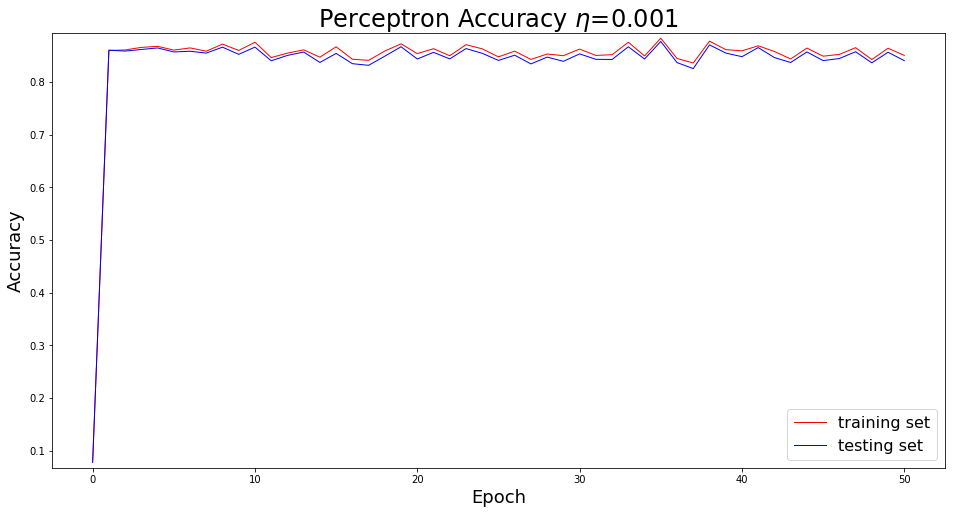

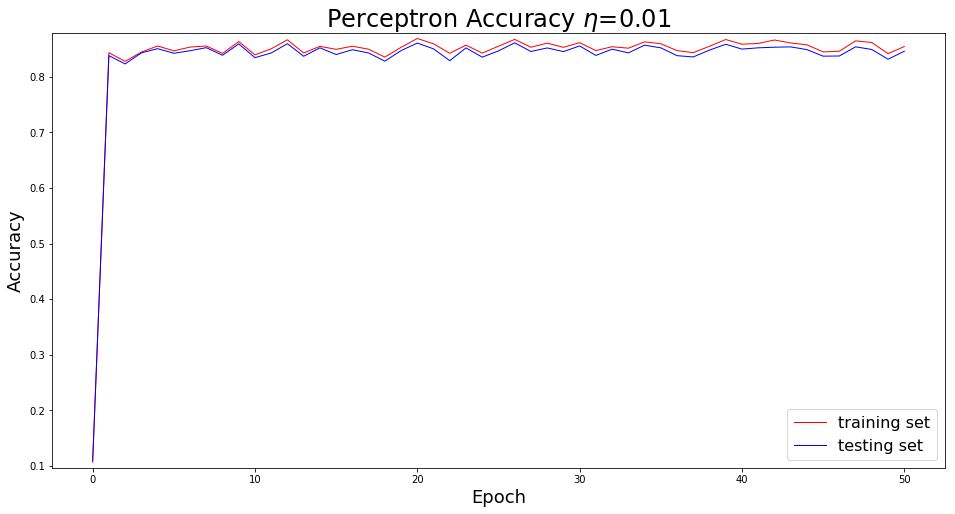

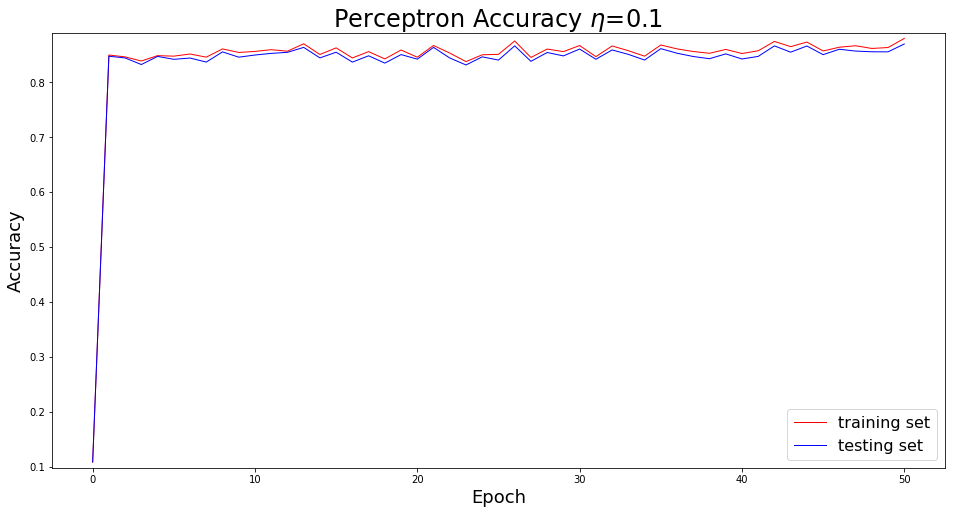

In [15]:
for eta in etas:
    plot_accuracy_graphs(training_accuracy[eta], testing_accuracy[eta], eta)

In [12]:
print('Total time: {:.2f} minutes'.format((datetime.now() - assignment_start) / timedelta(minutes=1)))

Total time: 6.02 minutes
